In [32]:
import sys
print("Chemin de l'exécutable Python :", sys.executable)
print("Version de Python :", sys.version)

Chemin de l'exécutable Python : c:\Users\micha\AppData\Local\Programs\Python\Python311\python.exe
Version de Python : 3.11.1 (tags/v3.11.1:a7a450f, Dec  6 2022, 19:58:39) [MSC v.1934 64 bit (AMD64)]


In [17]:
%matplotlib inline
# Load all necessary packages
# import sys
# sys.path.append("../")
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import random

### Some usefull functions

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
import random
import numpy as np
import pandas as pd
def train_classifier(train_dataset, test_dataset, model, threshold=0.5, random_seed=None):
    """
    Trains a classification model, normalizes the data, and evaluates its performance.
    
    Arguments:
    - train_dataset: Training dataset (must contain features, labels, and instance_weights).
    - test_dataset: Testing dataset.
    - model: The model class (e.g., LogisticRegression, RandomForestClassifier).
    - threshold: The threshold to classify probabilities into binary labels (default = 0.5).
    - random_seed: Seed value for reproducibility (default = None).
    
    Returns:
    - classifier: The trained model.
    - metrics: A dictionary containing evaluation metrics (accuracy, precision, recall) on the test set.
    """
    # Set the random seed for reproducibility
    if random_seed is not None:
        random.seed(random_seed)  # For Python's random module
        np.random.seed(random_seed)  # For NumPy

    # Initialize the standard scaler
    scaler = StandardScaler()
    
    # 1. Normalize the training data
    X_train = scaler.fit_transform(train_dataset.features)  # Normalize the features
    y_train = train_dataset.labels.ravel()  # Extract target labels
    w_train = train_dataset.instance_weights.ravel()  # Extract instance weights (if available)

    # 2. Train the model
    # Use the random seed if the model supports the 'random_state' parameter
    classifier = model(random_state=random_seed) if 'random_state' in model().get_params() else model()
    classifier.fit(X_train, y_train, sample_weight=w_train)
    
    # 3. Predictions on the training set
    y_train_pred = classifier.predict(X_train)
    
    # Identify the positive class (e.g., income > 50K)
    pos_ind = np.where(classifier.classes_ == train_dataset.favorable_label)[0][0]

    # 4. Prepare the testing data
    X_test = scaler.transform(test_dataset.features)  # Normalize the test features
    y_test = test_dataset.labels  # Extract the actual test labels
    
    # Predict probabilities for the positive class
    test_scores = classifier.predict_proba(X_test)[:, pos_ind].reshape(-1, 1)
    
    # Convert scores into binary predictions using the specified threshold
    y_test_pred = (test_scores > threshold).astype(int)
    
    # Compute main evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)

    # Display a preview of the first 10 probability scores
    print("Test set scores (first 10 predictions):")
    print(test_scores[:10])
    
    # Prepare the metrics as a pandas DataFrame
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall'],
        'Value': [accuracy, precision, recall]
    })
    
    # Return the trained model and the metrics DataFrame
    return classifier, metrics_df, y_test_pred

1. - Preprocess the data
- binarize Age. 
- Split the data into train, validation, test sets
- train a classifier
- Measure the performance of the classifier on the test set. 

In [31]:
random_seed = 42
# A -------------------------------- Import dataaset and binarize age ----------------------------------------------

# Import dataset
dataset_orig = AdultDataset()
# Convert to dataframe to visualize it
data, _ = dataset_orig.convert_to_dataframe()
# Copy only to binarize age (Threshold = 40 years)
binarised = data.copy()
binarised['age'] = binarised['age'].apply(lambda x: 0 if x <= 40 else 1) # 1 if greater than 40
# B ----------------------------- Split into train, validation and test --------------------------------------------
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)
# C ----------------------------- Train a classifier and check for the predictions, and the performances --------------------------------------------
the_classifier, metrics_of_the_classifer, y_test_predictions = train_classifier(train_dataset=dataset_orig_train,
                                                            test_dataset= dataset_orig_test,
                                                            model=LogisticRegression,
                                                            threshold=0.5,
                                                            random_seed=random_seed)
print("\nEvaluation of the classifier's metrics:")
print(metrics_of_the_classifer)

Test set scores (first 10 predictions):
[[0.05110014]
 [0.01196516]
 [0.05237648]
 [0.64457542]
 [0.61894245]
 [0.48253575]
 [0.01588735]
 [0.00462869]
 [0.00106118]
 [0.26590193]]

Evaluation of the classifier's metrics:
      Metric     Value
0   Accuracy  0.843897
1  Precision  0.722539
2     Recall  0.601901


2. - Assess the group fairness of the classifier, assuming the protected attributes are Age, Sex. 
- apply a technique to ensure the classifier is fair.

In [34]:
random_seed = 42
random.seed(random_seed) 
np.random.seed(random_seed)

# A -------- Assess the group fairness of the classifier, assuming the protected attributes are Age, Sex ------------ 

privileged_groups = [{'sex': 1}]  # Men are priviledged
unprivileged_groups = [{'sex': 0}]  

test_predicted = dataset_orig_test.copy()
test_predicted.labels = y_test_predictions  # Prédictions du classifier

print("\nInstance weights before reweighting:")
print(test_predicted.instance_weights[:10])  
# Compute fairness of the classifier (test set)
metric_test_classifier = BinaryLabelDatasetMetric(test_predicted, 
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups)

display(Markdown("#### Test set fairness metrics (classifier):"))
print("Statistical Parity Difference (classifier):", metric_test_classifier.statistical_parity_difference())

# B ---------------- apply a technique to ensure the classifier is fair  ----------------------------------------------

RW = Reweighing(unprivileged_groups=unprivileged_groups, 
                privileged_groups=privileged_groups)
dataset_train_transf = RW.fit_transform(dataset_orig_train)

print("\nInstance weights after reweighting:")
print(dataset_train_transf.instance_weights[:10])  

metric_transf_train = BinaryLabelDatasetMetric(dataset_train_transf, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
print("\n")
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups (Sex):")
print(metric_transf_train.statistical_parity_difference())

# C ------------------------- Train our 'fair classifier' on the new dataset ----------------------------------------------
fair_classifier, fair_metrics, y_test_pred_fair = train_classifier(
    train_dataset=dataset_train_transf,  # Transformed dataset
    test_dataset=dataset_orig_test,      # Same test dataset
    model=LogisticRegression,
    threshold=0.5,
    random_seed=42
)
# Display metrics for the fair classifier
print("\nFair Classifier Metrics:")
print(fair_metrics)


Instance weights before reweighting:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


#### Test set fairness metrics (classifier):

Statistical Parity Difference (classifier): -0.17871986305566923

Instance weights after reweighting:
[0.8457202  1.09594426 0.78982139 1.09594426 1.09594426 0.78982139
 0.78982139 1.09594426 0.8457202  1.09594426]




#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups (Sex):
5.551115123125783e-17
Test set scores (first 10 predictions):
[[0.0344237 ]
 [0.00917653]
 [0.12897345]
 [0.56631903]
 [0.54080346]
 [0.41756688]
 [0.03856527]
 [0.00350017]
 [0.0005973 ]
 [0.20684067]]

Fair Classifier Metrics:
      Metric     Value
0   Accuracy  0.836527
1  Precision  0.723520
2     Recall  0.551990


## Comparison of the metrics for both classifiers

In [35]:
# Display metrics for the main classifier
print("\nMain Classifier Metrics:")
print(metrics_of_the_classifer)

# Display metrics for the fair classifier
print("\nFair Classifier Metrics:")
print(fair_metrics)


Main Classifier Metrics:
      Metric     Value
0   Accuracy  0.843897
1  Precision  0.722539
2     Recall  0.601901

Fair Classifier Metrics:
      Metric     Value
0   Accuracy  0.836527
1  Precision  0.723520
2     Recall  0.551990


# 3 - Privacy :
- Cross tabulation showing the nb of persons for each combinations of Age and Sexe

In [36]:
import pandas as pd

cross_tab = pd.crosstab(index=binarised['age'],  # Age (binarisé : 0=Jeune, 1=Âgé)
                        columns=binarised['sex'],  # Sex (0=Femme, 1=Homme)
                        rownames=['Age'],
                        colnames=['Sex'])

cross_tab['Total'] = cross_tab.sum(axis=1)  # Totaux des lignes
cross_tab.loc['Total'] = cross_tab.sum(axis=0)  # Totaux des colonnes

# Afficher la cross-tabulation
print("\nCross-tabulation of Age and Sex:")
cross_tabulation_frame = pd.DataFrame(cross_tab)

print(f"There are {cross_tab[0.0][0]} young females (Age=0, Sex=0.0).")
print(f"There are {cross_tab[1.0][0]} young males (Age=0, Sex=1.0).")
print(f"There are {cross_tab[0.0][1]} aged females (Age=1, Sex=0.0).")
print(f"There are {cross_tab[1.0][1]} aged males (Age=1, Sex=1.0).")

print(f"Total young people (Age=0): {cross_tab['Total'][0]}.")
print(f"Total aged people (Age=1): {cross_tab['Total'][1]}.")

print(f"Total females (Sex=0.0): {cross_tab[0.0]['Total']}.")
print(f"Total males (Sex=1.0): {cross_tab[1.0]['Total']}.")
print(f"Grand total: {cross_tab['Total']['Total']}.")

cross_tabulation_frame


Cross-tabulation of Age and Sex:
There are 9248 young females (Age=0, Sex=0.0).
There are 17303 young males (Age=0, Sex=1.0).
There are 5447 aged females (Age=1, Sex=0.0).
There are 13224 aged males (Age=1, Sex=1.0).
Total young people (Age=0): 26551.
Total aged people (Age=1): 18671.
Total females (Sex=0.0): 14695.
Total males (Sex=1.0): 30527.
Grand total: 45222.


Sex,0.0,1.0,Total
Age,,,
0,9248,17303,26551
1,5447,13224,18671
Total,14695,30527,45222


B - Local differential privacy on age and sex and generation of a new noisy dataset

In [37]:
import random

def rand_resp(x, p=0.75, q=0.75):
    toss = random.random()
    if x == 0:
        y = 0 if toss <= q else 1
    else:
        y = 1 if toss <= p else 0
    return y

In [38]:

for epsilon in [0.1, 0.5, 1.0, 2.0]:
    p, q = np.exp(epsilon) / (1 + np.exp(epsilon)), np.exp(epsilon) / (1 + np.exp(epsilon))
    
    binarised_private = binarised.copy()
    # Add the noise to Age and Sex
    binarised_private['age'] = binarised['age'].apply(lambda x: rand_resp(x, p, q))
    binarised_private['sex'] = binarised['sex'].apply(lambda x: rand_resp(x, p, q))


Create a new noisy dataset for these attributes
and
Visualize the results (Test with various epsilon and quantify the divergence for each value) 

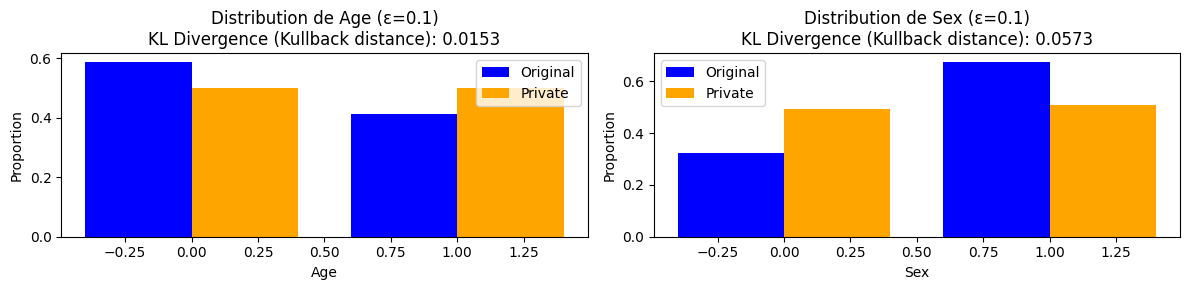

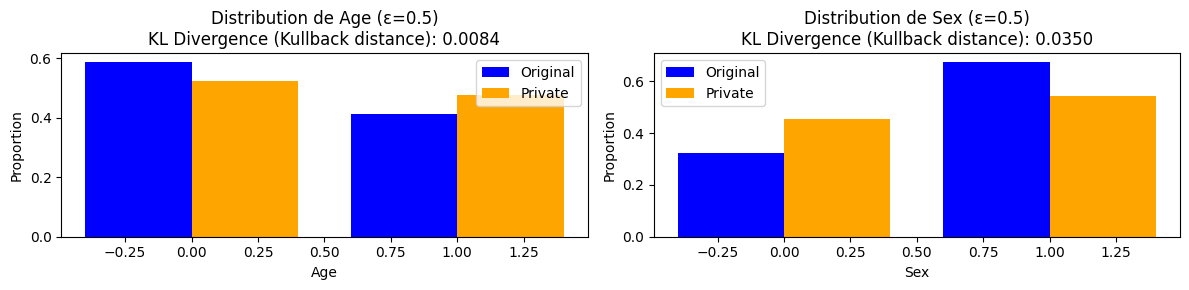

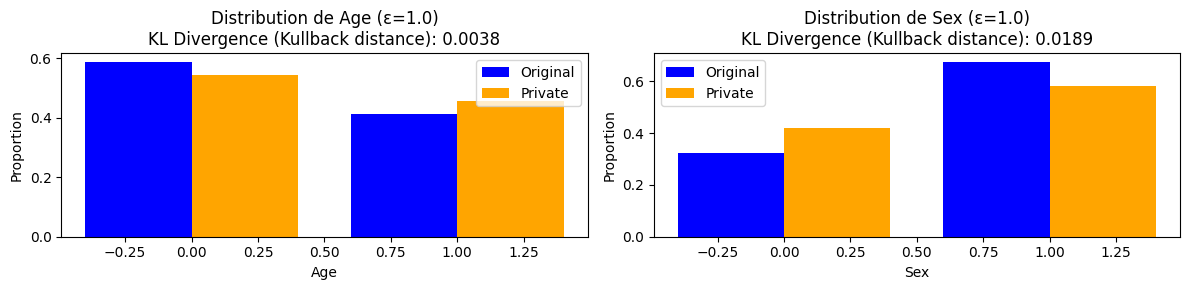

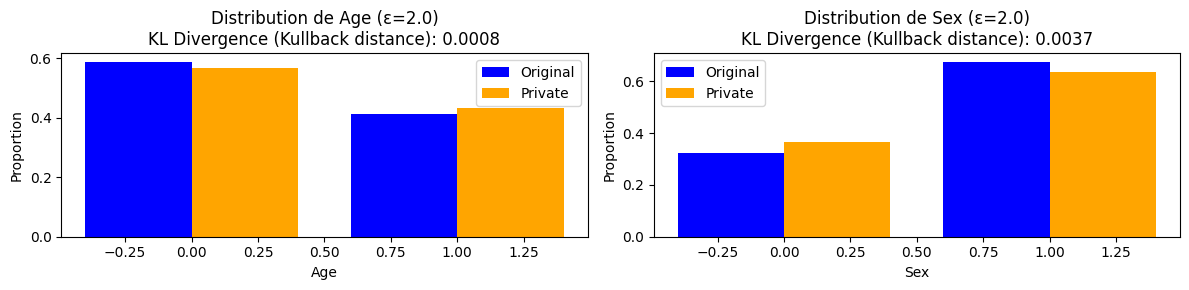

In [39]:
import matplotlib.pyplot as plt
import numpy as np

epsilon_values = [0.1, 0.5, 1.0, 2.0]
from scipy.stats import entropy

def kl_divergence(original_dist, private_dist):
    """
    Compute the kullback distance between the two distributions. 
    """
    # Normaliser les distributions (pour éviter les problèmes)
    original_dist = original_dist / original_dist.sum()
    private_dist = private_dist / private_dist.sum()
    
    # Calculer la divergence KL
    return entropy(original_dist, private_dist)

# Fonction pour tracer les histogrammes
def plot_distribution(original_data, private_data, epsilon):
    attributes = ['age', 'sex']  # Liste des attributs à comparer

    # Créer une figure avec deux subplots
    plt.figure(figsize=(12, 3))  # Taille ajustée pour deux subplots

    for i, att in enumerate(attributes, start=1):  # Boucle avec index pour subplot
        original_dist = original_data[att].value_counts(normalize=True)
        private_dist = private_data[att].value_counts(normalize=True)
        
        kl_div = kl_divergence(original_dist, private_dist)

        # Ajouter le subplot
        plt.subplot(1, 2, i)  # 1 ligne, 2 colonnes, ième subplot
        plt.bar(original_dist.index - 0.2, original_dist, width=0.4, label='Original', color='blue')
        plt.bar(private_dist.index + 0.2, private_dist, width=0.4, label='Private', color='orange')

        # Ajouter des labels et un titre
        plt.xlabel(att.capitalize())
        plt.ylabel('Proportion')
        plt.title(f'Distribution de {att.capitalize()} (ε={epsilon})\nKL Divergence (Kullback distance): {kl_div:.4f}')
        plt.legend()

    # Afficher les subplots côte à côte
    plt.tight_layout()
    plt.show()

# Boucle pour chaque epsilon
for epsilon in epsilon_values:
    p, q = np.exp(epsilon) / (1 + np.exp(epsilon)), np.exp(epsilon) / (1 + np.exp(epsilon))
    
    # Copy of the noisy dataset
    binarised_private = binarised.copy()
    binarised_private['age'] = binarised['age'].apply(lambda x: rand_resp(x, p, q))
    binarised_private['sex'] = binarised['sex'].apply(lambda x: rand_resp(x, p, q))
    
    # Plot the histograms with metric of divergence
    plot_distribution(binarised, binarised_private, epsilon)

- Cross tabulation for private dataset and quantify the errors in the estimations

In [12]:
import pandas as pd
import numpy as np

# Valeur d'epsilon choisie
epsilon = 1.0

# Probabilités de Randomized Response basées sur epsilon
p = np.exp(epsilon) / (1 + np.exp(epsilon))
q = 1 / (1 + np.exp(epsilon))

# Appliquer le bruit aux données originales
binarised_noisy_e1 = binarised.copy()  # Renommée pour éviter toute confusion
binarised_noisy_e1['age'] = binarised['age'].apply(lambda x: rand_resp(x, p, q))
binarised_noisy_e1['sex'] = binarised['sex'].apply(lambda x: rand_resp(x, p, q))

# Cross-tabulation pour les données originales
original_crosstab = pd.crosstab(binarised['age'], binarised['sex'], margins=True)

# Cross-tabulation pour les données privées
noisy_crosstab = pd.crosstab(binarised_noisy_e1['age'], binarised_noisy_e1['sex'], margins=True)

# Calcul des erreurs absolues
error_matrix = abs(original_crosstab - noisy_crosstab)

# Calcul des métriques globales
mae = error_matrix.mean().mean()  # Mean Absolute Error
rmse = ((error_matrix**2).mean().mean())**0.5  # Root Mean Squared Error

# Affichage des résultats
print(f"Cross-tabulation pour les données originales (Epsilon = {epsilon}):")
print(original_crosstab)

print(f"\nCross-tabulation pour les données privées (Epsilon = {epsilon}):")
print(noisy_crosstab)

print("\nMatrice des erreurs absolues :")
print(error_matrix)

print(f"\nMétriques globales :")
print(f"Mean Absolute Error (MAE) : {mae:.4f}")
print(f"Root Mean Squared Error (RMSE) : {rmse:.4f}")

Cross-tabulation pour les données originales (Epsilon = 1.0):
sex    0.0    1.0    All
age                     
0     9248  17303  26551
1     5447  13224  18671
All  14695  30527  45222

Cross-tabulation pour les données privées (Epsilon = 1.0):
sex      0      1    All
age                     
0     3249   8863  12112
1     8817  24293  33110
All  12066  33156  45222

Matrice des erreurs absolues :
sex   0.0    1.0    All
age                    
0    5999   8440  14439
1    3370  11069  14439
All  2629   2629      0

Métriques globales :
Mean Absolute Error (MAE) : 7001.5556
Root Mean Squared Error (RMSE) : 8640.3060


In [47]:
import pandas as pd
data_priv = binarised_noisy_e1
private_data = data_priv.copy()
# 1. Split the private dataset into train (70%), validation (15%), and test (15%)
private_train, private_vt = private_data.split([0.7], shuffle=True)  # 70% train
private_valid, private_test = private_vt.split([0.5], shuffle=True)  # 15% validation, 15% test

# 2. Train the private classifier using the train split
private_classifier, private_metrics, private_test_pred = train_classifier(
    train_dataset=private_train,
    test_dataset=private_test,
    model=LogisticRegression,
    threshold=0.5,
    random_seed=42
)

AttributeError: 'DataFrame' object has no attribute 'split'

Measure the performance of the private classifier. Is there an impact on model performance
due to privacy compared to the classifier?

In [44]:
# Compare metrics
print("\nComparison of Test Set Performance:")
comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall"],
    "Main Classifier": [metrics_of_the_classifer.loc[0, 'Value'], metrics_of_the_classifer.loc[1, 'Value'], metrics_of_the_classifer.loc[2, 'Value']],
    "Private Classifier": [private_metrics.loc[0, 'Value'], private_metrics.loc[1, 'Value'], private_metrics.loc[2, 'Value']]
})

print(comparison)


Comparison of Test Set Performance:
      Metric  Main Classifier  Private Classifier
0   Accuracy         0.843897            0.843897
1  Precision         0.722539            0.722539
2     Recall         0.601901            0.601901
